### Deep Reinforcement Learning for Super Mario World and the potential of RL models in Nuclear Fusion

#### Project Overview
The main goal of this project is to use deep reinforcement learning (DRL) to train a model to play Super Mario World on the SNES.  
The project will demonstrate the ability of RL models to use data as inputs and learn to prevent bad outcomes (from the reward function).  
Additionally, the proposal will explore the potential of DRL models in controlling devices in IoT, specifically in the context of nuclear fusion (to be seen).  
(The project will be divided into two parts: (1) training a DRL model to play Super Mario World, and (2) exploring the potential of DRL in controlling devices in IoT.)  

#### Data Description
The data for this project will come from the OpenAI Gym Retro environment, which provides an emulator for Super Mario World.  
The dataset consists of frames from the game, along with actions taken by the model and the corresponding rewards.  
The dataset will need to be preprocessed to extract features that are relevant to the DRL model.  

#### Methodology
The DRL model will be trained using the Proximal Policy Optimization (PPO) algorithm.  
The DRL model will be evaluated using a set of metrics, including the average score achieved and the number of deaths.  
For the exploration of the potential of DRL in controlling devices in IoT, the project will use a simulated environment to test the model's ability to control the parameters of the system.  

#### The timeline for completing the project is as follows:
Week 1: Collect and preprocess data for Super Mario World  
Week 2: Train and evaluate the DRL model on Super Mario World  
Week 3: Visualize the model's progress  
Week 4: Explore the potential of DRL in controlling IoT devices  

#### Results Interpretation
The results of the Super Mario World model will be interpreted in terms of the average score achieved and the number of deaths.  
The results of the exploration of DRL in IoT will be interpreted in terms of the model's ability to control the parameters of the system and prevent failures.  
The interpretation of the results will be presented in a dashboard, which will include graphs and visualizations to make the results more interpretable.  

#### Deployment and Delivery
The DRL model will be deployed as a standalone application that can be run on a desktop computer.  
The application will be delivered with a user manual that provides instructions on how to use the application.  
Additionally, a dashboard will be provided to showcase the results of the project.  

#### Conclusion
The project will demonstrate the ability of DRL models to learn from data and prevent bad outcomes.  
The exploration of the potential of DRL in controlling devices in IoT will provide insights into how this technology can be applied in real-world scenarios.  
Overall, this project will showcase the potential of DRL in solving complex problems and preventing failures of complex systems.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import gym
import retro

import gym.envs.classic_control as control
from gym.wrappers import GrayScaleObservation

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

%load_ext tensorboard

2023-03-29 19:47:17.597316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 19:47:18.038868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
env = retro.make(game="SuperMarioWorld-Snes", state="YoshiIsland1", use_restricted_actions=retro.Actions.FILTERED)

In [3]:
obs = env.reset()

In [4]:
action = env.action_space.sample()
print(action)
env.get_action_meaning(action)

[1 1 0 0 1 0 0 1 0 1 0 0]


['B', 'Y', 'UP', 'RIGHT', 'X']

In [5]:
obs, reward, terminated, info = env.step(action)
print(f"score: {reward}\nterminated: {terminated}\ninfo: {info}")

score: 0.0
terminated: False
info: {'coins': 0, 'lives': 4, 'score': 0}


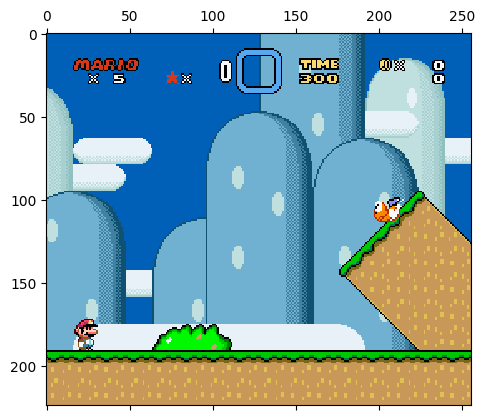

In [6]:
plt.matshow(obs)

In [ ]:
done = True
for step in range(100000): 
    if done: 
        env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()
    # time.sleep(1/100)

env.close()

In [7]:
# preprocess: grayscale, vectorize and framestacking
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda:env])
env = VecFrameStack(env, 4, channels_order="last")

In [8]:
state = env.reset()

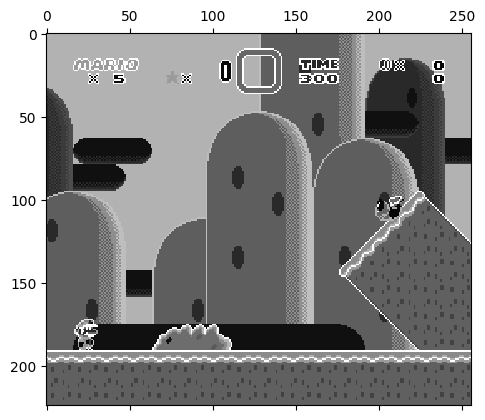

In [9]:
plt.matshow(state[0])

In [10]:
state.shape

(1, 224, 256, 4)

In [15]:
state, reward, done, info = env.step([env.action_space.sample()])

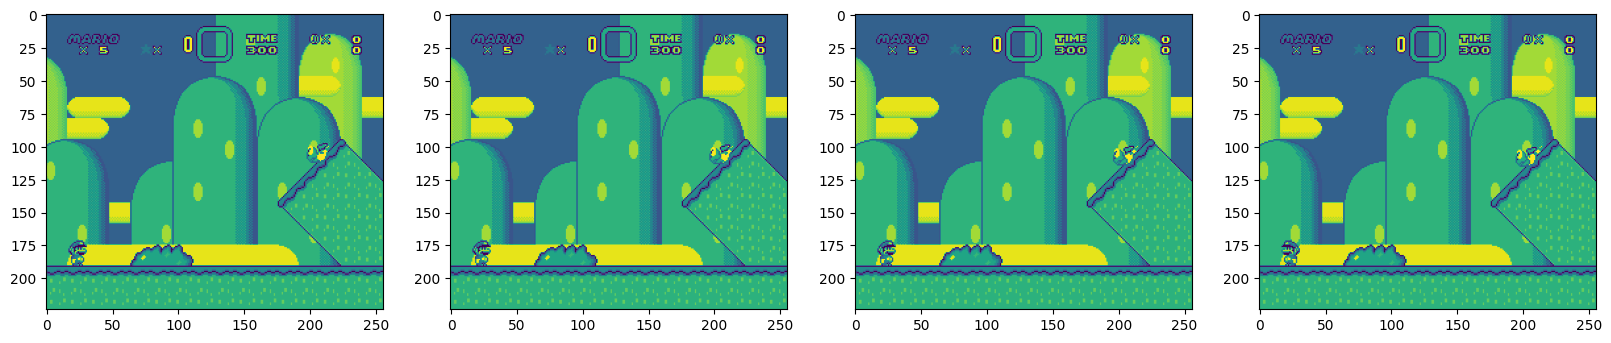

In [16]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [17]:
# callback helper function
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "best_model_{}".format(self.n_calls))
            self.model.save(model_path)

        return True

In [18]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"

In [ ]:
# callback
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [ ]:
model = PPO("CnnPolicy", env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.00001, 
            n_steps=128, n_epochs=10)

In [ ]:
model.learn(total_timesteps=10000000, callback=callback)

In [ ]:
model = PPO.load("./train/best_model_500000.zip")

In [ ]:
# game loop for predict
state = env.reset()

while True:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

In [ ]:
# NOTES

# 100k Nope.

# 200k Nope.

# 300k started really going to the right. kinda waits for the bullet spawn.  
# dies mostly from enemies.. randomly changes level lol

# 400k isnt too bad.. not sure if he can actually finish a level
# he struggles at jumping and struggles with the bullet or enemies in general

# 500k waits for the bullet sometimes, and uses R to move the screen right to spawn the bullet.. smart cookie!

# 600k+ Nope. LR was too high. overshot.